# Pretrained Models

## Base learners using pretrained models

### Base learners using Resnet152, AlexNet, Densenet161

Built using the function that Tyler created
The tb_preprocess.py script should be in the same folder as the notebook.

##### Need to add other models

In [1]:
modelnames = {'alexnet':'alexnet','resnet152':'resnet152','densenet161':'densenet161'}

#Set the Model name
model_param = 'densenet161'
filepath = '.'

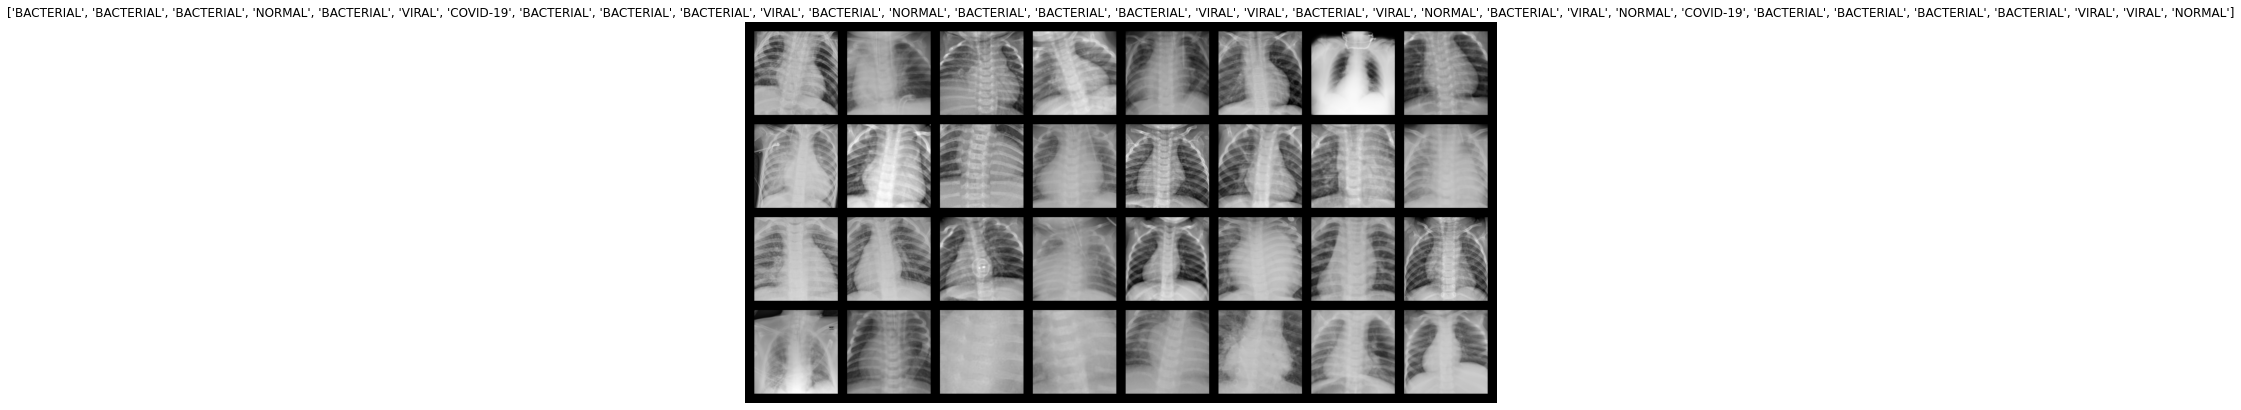

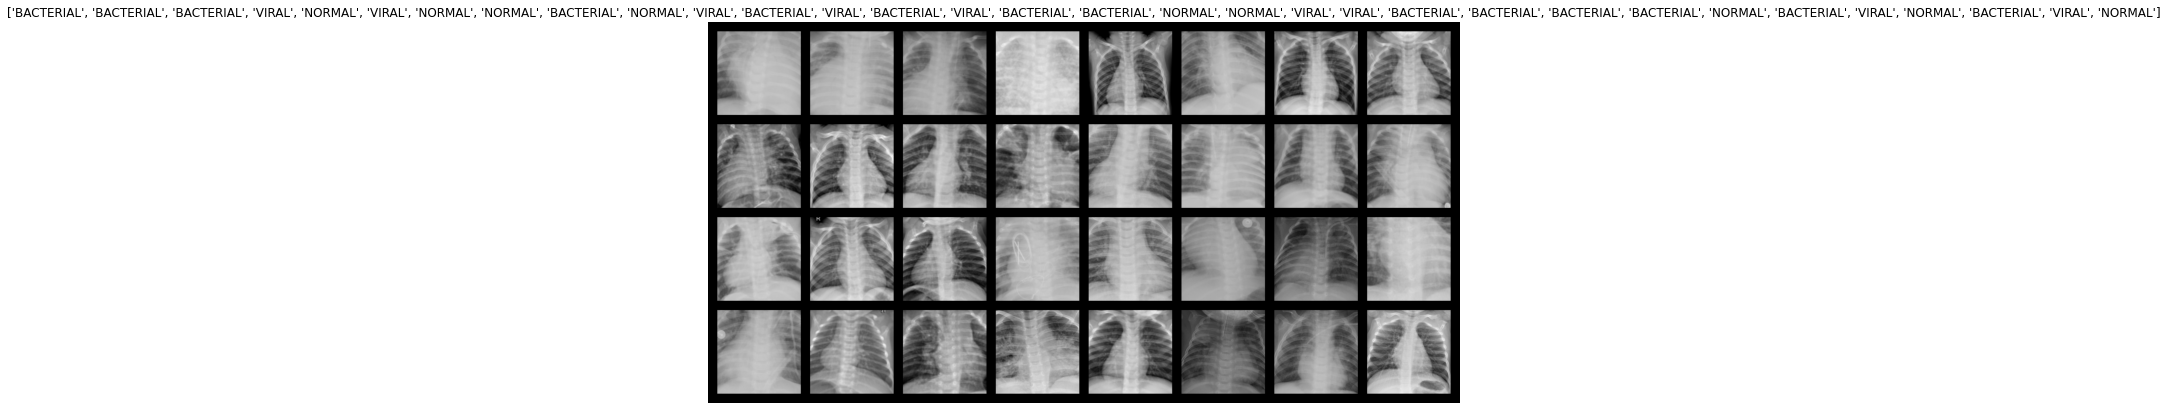

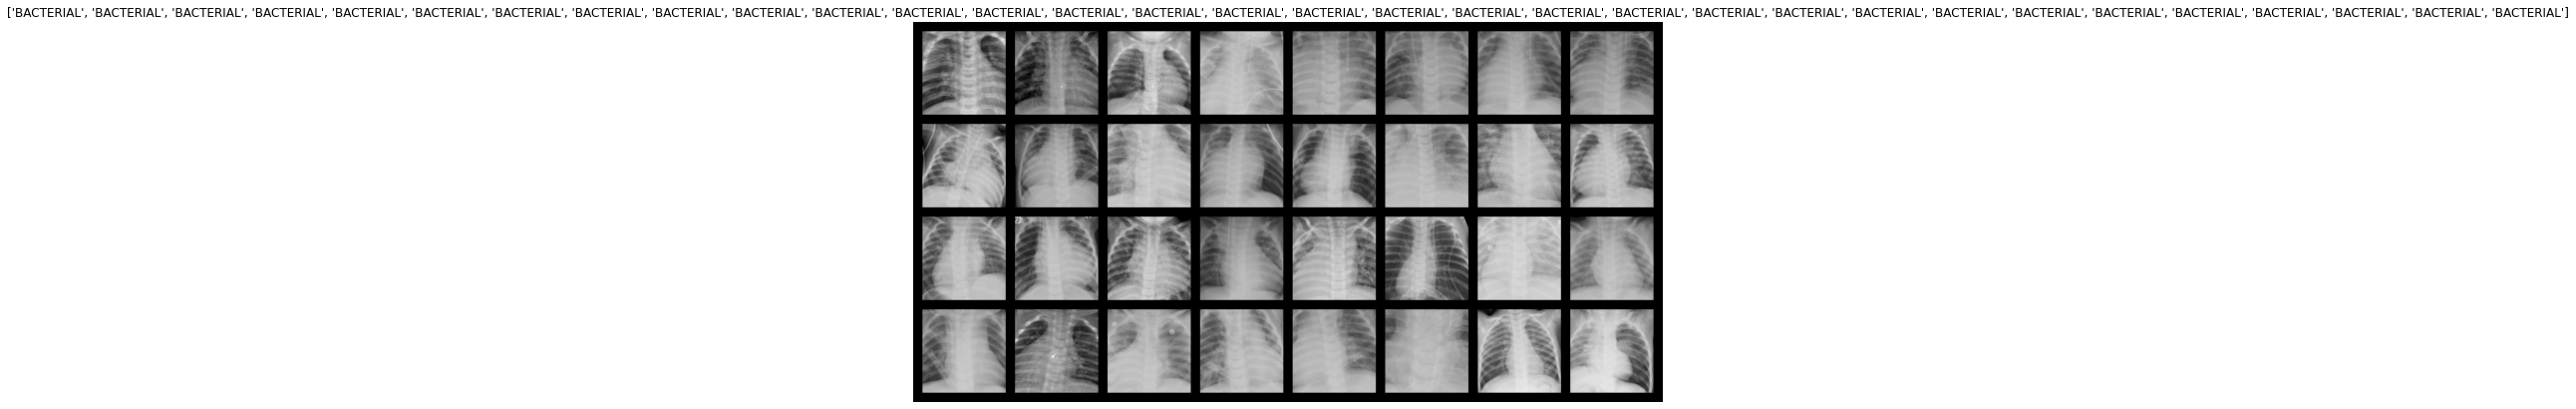

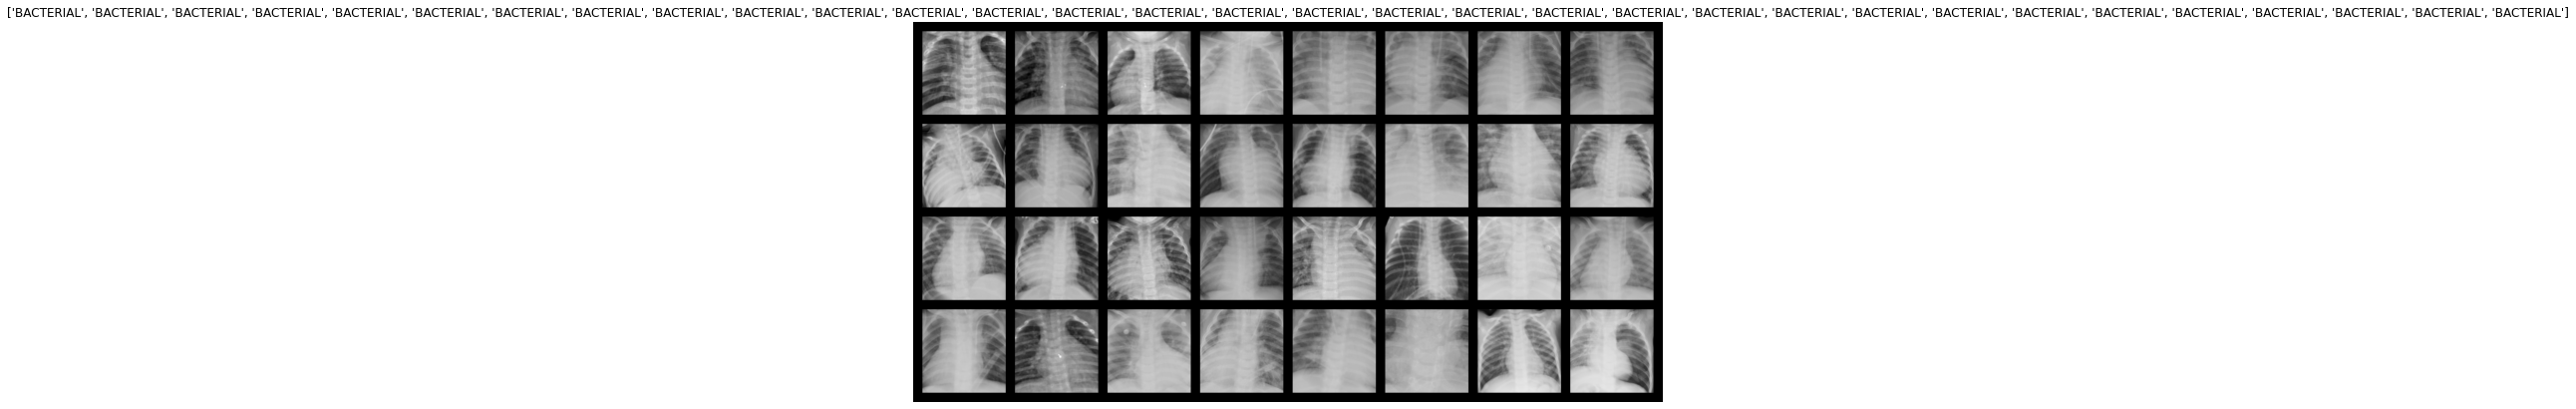

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time; _START_RUNTIME = time.time()
import gc

from torchvision import models


#Use the preprocess function from tb_preprocess.py to load the datasets
from tb_preprocess_multi import load_data

train_loader_base, val_loader_base, train_loader_red, val_loader_red = load_data() 
  

idx2class = {'bacterial': 0, 'covid-19': 1, 'normal': 2, 'viral': 3}
classes = ('Bacterial','Covid-19', 'Normal', 'Viral')

train_loader = train_loader_base
val_loader = val_loader_base



### Use the model that is pretrained. 

##### Model selection is hardcoded for now


In [3]:
gc.collect()
torch.cuda.empty_cache()

red_model = models.__dict__[model_param](pretrained=True)



#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and model to GPU for speed if available
red_model.to(device)




cuda:0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

#### Change the last linear layer to match the number of classes. In this case 4.

##### Eg:- The standard Alexnet model has 1000 out features for the last Linear layer. Since the data set only has 3 classes, change the last layer to have 3 outs

In [4]:

if model_param == 'alexnet':
    red_model.classifier[6] = torch.nn.Linear(red_model.classifier[6].in_features, 4, bias=True)
elif model_param == 'resnet152':
    red_model.fc = torch.nn.Linear(2048, 4, bias=True)
elif model_param == 'densenet161':
    red_model.classifier = torch.nn.Linear(2208, 4, bias=True)
    
red_model.eval()


if model_param == 'alexnet':
    red_model.features = torch.nn.DataParallel(red_model.features)
    red_model.cuda()
else:
    red_model = torch.nn.DataParallel(red_model).cuda()
    

#### Criterion and Optimizer

In [5]:
import torch.optim as optim

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(red_model.parameters(), lr=0.001, momentum=0.9)

### Training Alexnet

In [6]:
#Epochs is set to 1. Performace is slow
#Need to try CUDA to speed up

n_epochs = 25

gc.collect()
torch.cuda.empty_cache()

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

    # prep model for training
    model.train() 
    
    for epoch in range(n_epoch):
        
        EPOCH_START = time.time()
        
        curr_epoch_loss = []
        
        for data, target in train_dataloader:
            
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model(data)
            #print(output)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            curr_epoch_loss.append(loss.cpu().data.numpy())
            
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        print("Training time = {:.2f} seconds".format(time.time() - EPOCH_START))
    
    return model


gc.collect()
torch.cuda.empty_cache()

### Save the model

In [7]:
trainedmodel = model_param + '.pth'

gc.collect()
torch.cuda.empty_cache()

if os.path.exists(trainedmodel):
    print('Model is trained - ' + model_param)
    red_model = torch.load(trainedmodel)
    red_model.to(device)
else:
    red_model = train_model(red_model, train_loader)
    torch.save(red_model, trainedmodel)
    print("Total running time = {:.2f} seconds".format(time.time() - _START_RUNTIME))
    


Epoch 0: curr_epoch_loss=0.6503913998603821
Training time = 375.68 seconds
Epoch 1: curr_epoch_loss=0.4301731586456299
Training time = 375.34 seconds
Epoch 2: curr_epoch_loss=0.35670000314712524
Training time = 374.51 seconds
Epoch 3: curr_epoch_loss=0.2929348349571228
Training time = 375.91 seconds
Epoch 4: curr_epoch_loss=0.22775645554065704
Training time = 370.43 seconds
Epoch 5: curr_epoch_loss=0.17716209590435028
Training time = 371.39 seconds
Epoch 6: curr_epoch_loss=0.1362633854150772
Training time = 370.40 seconds
Epoch 7: curr_epoch_loss=0.09713476151227951
Training time = 367.48 seconds
Epoch 8: curr_epoch_loss=0.0759100690484047
Training time = 372.49 seconds
Epoch 9: curr_epoch_loss=0.04882381483912468
Training time = 372.58 seconds
Epoch 10: curr_epoch_loss=0.04224126413464546
Training time = 369.29 seconds
Epoch 11: curr_epoch_loss=0.041200902312994
Training time = 367.66 seconds
Epoch 12: curr_epoch_loss=0.047698576003313065
Training time = 368.25 seconds
Epoch 13: curr_

#### Testing

Validation Accuracy: 0.8298045602605864
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83       555
         1.0       0.98      0.97      0.97        59
         2.0       0.94      0.97      0.95       315
         3.0       0.68      0.62      0.65       299

    accuracy                           0.83      1228
   macro avg       0.86      0.85      0.85      1228
weighted avg       0.83      0.83      0.83      1228

Confusion Matrix
[[471   0   6  78]
 [  0  57   2   0]
 [  2   0 305   8]
 [101   1  11 186]]
Confusion Matrix Display


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=('Bacterial', 'Covid-19', 'Normal', 'Viral') as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


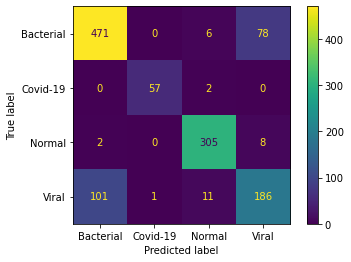

In [8]:
def eval_model(model, dataloader):

    model.eval()
    Y_pred = []
    Y_test = []
    with torch.no_grad():
        for data, target in dataloader:

            data, target = data.cuda(), target.cuda()
        
            output = model(data)
            #print(output.data)
            #print(target)
            _, y_predicted = torch.max(output.data, 1)
        
            Y_pred = np.append(Y_pred,y_predicted.detach().cpu().numpy())
            Y_test = np.append(Y_test,target.detach().cpu().numpy())

        return Y_pred, Y_test

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred, y_true = eval_model(red_model, val_loader)
acc = accuracy_score(y_true, y_pred)

print(("Validation Accuracy: " + str(acc)))

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=idx2class, index=idx2class)

cm = confusion_matrix(y_true, y_pred)
#print(cm)

print('Confusion Matrix Display')
cm_display = ConfusionMatrixDisplay(cm,classes).plot()


## Testing Accuracy

Classification accuracy of the test model.

In [9]:

correct = 0
total = 0

# no_grad impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = red_model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct)
print(total)
print('Accuracy of the network on test X-rays : %d %%' % ( 100 * correct / total))



1012
1228
Accuracy of the network on test X-rays : 82 %


## Individual Classes


In [10]:
for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
         classes[i], 100 * cm[i][i] / cm.sum(axis=1)[i]))


Accuracy of Bacterial : 84 %
Accuracy of Covid-19 : 96 %
Accuracy of Normal : 96 %
Accuracy of Viral : 62 %
